In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from matplotlib import colors as mcolors

import scanpy as sc
import squidpy as sq
import cellcharter as cc
import scvi

from pandas.api.types import is_numeric_dtype, is_categorical_dtype
from scipy.sparse import issparse

import sys
sys.path.append("/Users/christoffer/work/karolinska/development/MANA")
from utils import aggregate_neighbors_weighted, plot_spatial_compact_fast



# adding raw data to object

In [5]:
ad_sub = sc.read_h5ad('/Volumes/processing2/nature-dev-mouse-reanalysis/ad_all_processed.h5ad')

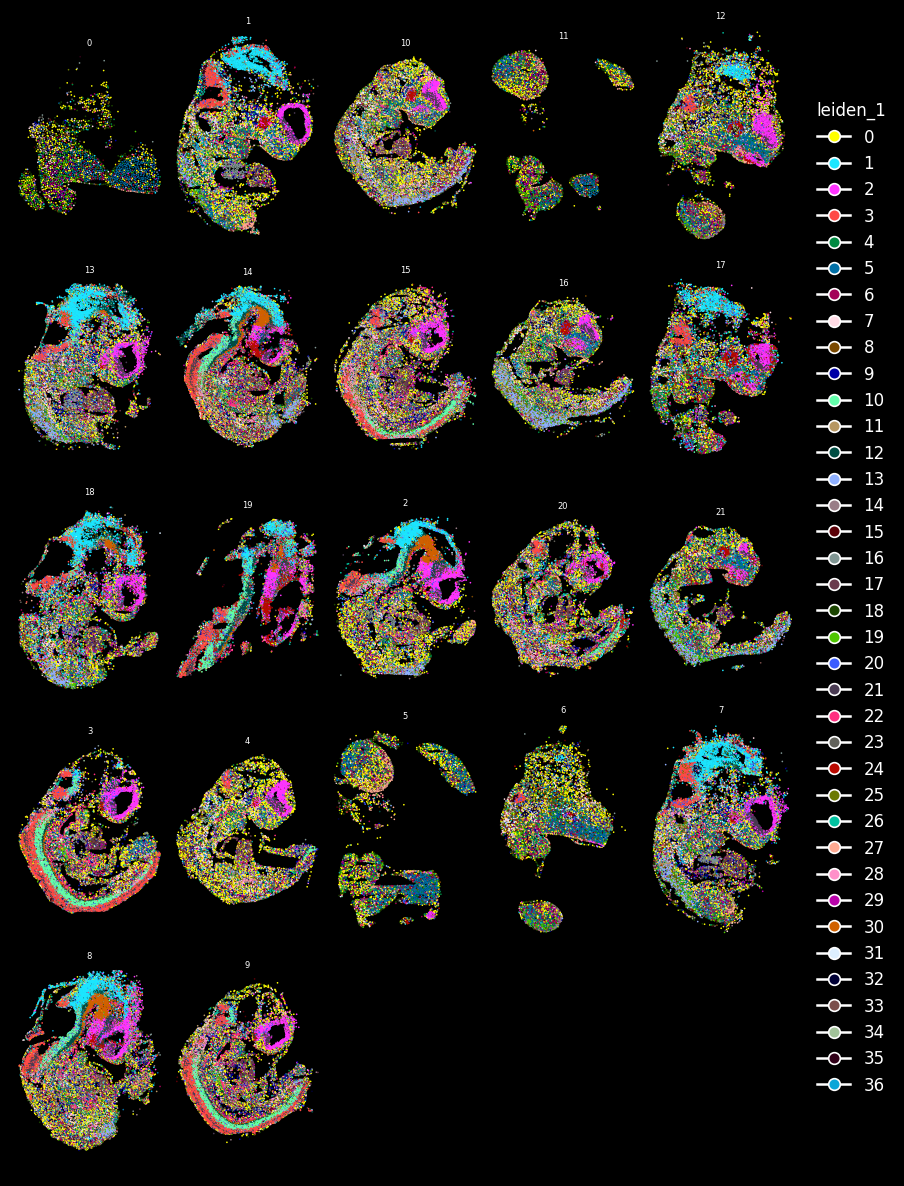

In [8]:
# usage
plot_spatial_compact_fast(
    ad_sub,
    color="leiden_1",
    groupby="section",
    spot_size=1,
    cols=5,
    height=10,
    legend_col_width=1.0,
    background="black",
    grey_alpha=0.05,
    #highlight=['4','5']
)

In [7]:
# Ensure all layers are sparse CSR matrices
from scipy.sparse import csr_matrix, issparse

for name, layer in list(ad_sub.layers.items()):
    if not issparse(layer):
        ad_sub.layers[name] = csr_matrix(layer)

# Optional: verify
{k: type(v).__name__ for k, v in ad_sub.layers.items()}


{'counts': 'csr_matrix'}

In [8]:

sc.pp.highly_variable_genes(
    ad_sub,
    n_top_genes=500,     # try 1500–2000
    flavor="seurat_v3"
)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
ad_sub = ad_sub[:, ad_sub.var["highly_variable"]].copy()

In [12]:
ad_sub

AnnData object with n_obs × n_vars = 299150 × 500
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'leiden_0.5', 'output_folder_2', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'cytetype_annotation_leiden_3.5', 'cytetype_cellOntologyTerm_leiden_3.5', 'cell_class', 'cell_subclass', 'cluster_cellcharter_2', 'cluster_cellcharter_5', 'cluster_cellcharter_10', 'cluster_cellcharter_15', 'cluster_cellcharter_20', 'cluster_cellcharter_25', 'cluster_cellcharter_30', 'cluster_cellcharter_40', 'cluster_cellcharter_50', 'slide', 'sample_name', 'ED', 'age', 'score EHS ', 'status', 'Erection per op', 'Diabetes', 'Prostatectomy', 'Other pathologies', 'anti testosterone', 'estradiol treatment', 'progesterone treatment', 'Testosterone level', 'estradiol level', 'progesterone level', 'sample_name_updated', 'PAT-ID', 'condition_

In [13]:
scvi.model.SCVI.setup_anndata(
    ad_sub, 
    layer="counts", 
    batch_key='sample_name_updated',
)

model = scvi.model.SCVI(ad_sub)

In [14]:
model.train(early_stopping=True, max_epochs = 30, enable_progress_bar=True)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores


Epoch 30/30: 100%|██████████| 30/30 [09:55<00:00, 20.18s/it, v_num=1, train_loss_step=90.8, train_loss_epoch=85.6]

`Trainer.fit` stopped: `max_epochs=30` reached.


Epoch 30/30: 100%|██████████| 30/30 [09:55<00:00, 19.85s/it, v_num=1, train_loss_step=90.8, train_loss_epoch=85.6]


In [15]:
ad_sub

AnnData object with n_obs × n_vars = 299150 × 500
    obs: 'cell', 'centroid_x', 'centroid_y', 'centroid_z', 'component', 'volume', 'surface_area', 'scale', 'region', 'sample_id', 'proseg_cluster', 'output_folder', 'Num', 'n_genes', 'n_counts', 'leiden_0.5', 'output_folder_2', 'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5', 'leiden_3', 'leiden_3.5', 'cytetype_annotation_leiden_3.5', 'cytetype_cellOntologyTerm_leiden_3.5', 'cell_class', 'cell_subclass', 'cluster_cellcharter_2', 'cluster_cellcharter_5', 'cluster_cellcharter_10', 'cluster_cellcharter_15', 'cluster_cellcharter_20', 'cluster_cellcharter_25', 'cluster_cellcharter_30', 'cluster_cellcharter_40', 'cluster_cellcharter_50', 'slide', 'sample_name', 'ED', 'age', 'score EHS ', 'status', 'Erection per op', 'Diabetes', 'Prostatectomy', 'Other pathologies', 'anti testosterone', 'estradiol treatment', 'progesterone treatment', 'Testosterone level', 'estradiol level', 'progesterone level', 'sample_name_updated', 'PAT-ID', 'condition_

In [16]:
# Get scVI latent representation
ad_sub.obsm['X_scVI'] = model.get_latent_representation()

print(f"Added X_scVI to ad_sub.obsm with shape: {ad_sub.obsm['X_scVI'].shape}")

Added X_scVI to ad_sub.obsm with shape: (299150, 10)


In [17]:
import squidpy as sq

# Build spatial graph
# This should be done per-sample to avoid creating edges between samples
sq.gr.spatial_neighbors(
    ad_sub,
    coord_type='generic',
    delaunay=True,  # Delaunay triangulation (connects nearby cells)
    key_added='spatial',
    library_key='sample_name_updated'  # Ensure no edges between different samples,
)

print(f"Spatial graph built: {ad_sub.obsp['spatial_connectivities'].shape}")
print(f"Average neighbors per cell: {ad_sub.obsp['spatial_connectivities'].sum(axis=1).mean():.1f}")

Spatial graph built: (299150, 299150)
Average neighbors per cell: 6.0


In [18]:
import cellcharter as cc

In [19]:
cc.gr.remove_long_links(ad_sub)

In [20]:
# Run MANA with memory-efficient per-sample processing
# Adjust 'sample_key' to match your actual sample column name!

aggregate_neighbors_weighted(
    ad_sub,
    n_layers=3,              # Optimal balance (from MANA-5)
    aggregations='mean',     # Standard aggregation
    use_rep='X_scVI',        # Use scVI latent space
    out_key='X_mana_gauss',  # Output key
    hop_decay=0.2,           # Optimal decay (from MANA-4)
    distance_kernel='gaussian',  # Winner from MANA-6 benchmark
    spatial_key='spatial',
    normalize_weights=True,
    include_self=True,
    sample_key='sample_name_updated',  # CRITICAL: Process per-sample to avoid memory issues!
)

print("\nMANA aggregation complete!")
print(f"Output stored in adata.obsm['X_mana_gauss'] with shape: {ad_sub.obsm['X_mana_gauss'].shape}")

Processing 32 samples separately for memory efficiency...
  Processing sample 1/32: V1-045148 (16,620 cells)
  Processing sample 2/32: V4-045148 (16,535 cells)
  Processing sample 3/32: IP3-045148 (17,577 cells)
  Processing sample 4/32: V2-045148 (2,615 cells)
  Processing sample 5/32: IP11-045148 (4,838 cells)
  Processing sample 6/32: V9-045148 (1,663 cells)
  Processing sample 7/32: V12-045148 (13,243 cells)
  Processing sample 8/32: IP8-045148 (6,557 cells)
  Processing sample 9/32: V6-045148 (22,276 cells)
  Processing sample 10/32: V8-045148 (5,077 cells)
  Processing sample 11/32: V10-045148 (8,258 cells)
  Processing sample 12/32: V7-045148 (9,329 cells)
  Processing sample 13/32: IP9-045148 (6,251 cells)
  Processing sample 14/32: IP7-045148 (12,106 cells)
  Processing sample 15/32: IP2-045148 (1,270 cells)
  Processing sample 16/32: IP10-045148 (2,073 cells)
  Processing sample 17/32: V9-045149 (7,714 cells)
  Processing sample 18/32: IP3-045149 (18,549 cells)
  Processing s

In [21]:
# Build neighborhood graph in MANA feature space
sc.pp.neighbors(
    ad_sub,
    use_rep='X_mana_gauss',
    n_neighbors=15,
    key_added='mana'
)

print("Neighbor graph built in MANA feature space")

Neighbor graph built in MANA feature space


In [1]:
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5,2]

In [ ]:
list_ = []
for res in resolutions: 
    key_added=f'leiden_mana_{res}'
    print(key_added)
    list_.append(key_added)

leiden_mana_0.3
leiden_mana_0.5
leiden_mana_0.8
leiden_mana_1.0
leiden_mana_1.5
leiden_mana_2


In [5]:
list_

['leiden_mana_0.3',
 'leiden_mana_0.5',
 'leiden_mana_0.8',
 'leiden_mana_1.0',
 'leiden_mana_1.5',
 'leiden_mana_2']

In [22]:
# Leiden clustering
# Try a few resolutions to see what works best
resolutions = [0.3, 0.5, 0.8, 1.0, 1.5,2]

for res in resolutions:
    sc.tl.leiden(
        ad_sub,
        resolution=res,
        key_added=f'leiden_mana_{res}',
        neighbors_key='mana'
    )
    n_clusters = ad_sub.obs[f'leiden_mana_{res}'].nunique()
    print(f"Resolution {res}: {n_clusters} clusters")

Resolution 0.3: 6 clusters
Resolution 0.5: 9 clusters
Resolution 0.8: 13 clusters
Resolution 1.0: 16 clusters
Resolution 1.5: 22 clusters
Resolution 2: 29 clusters


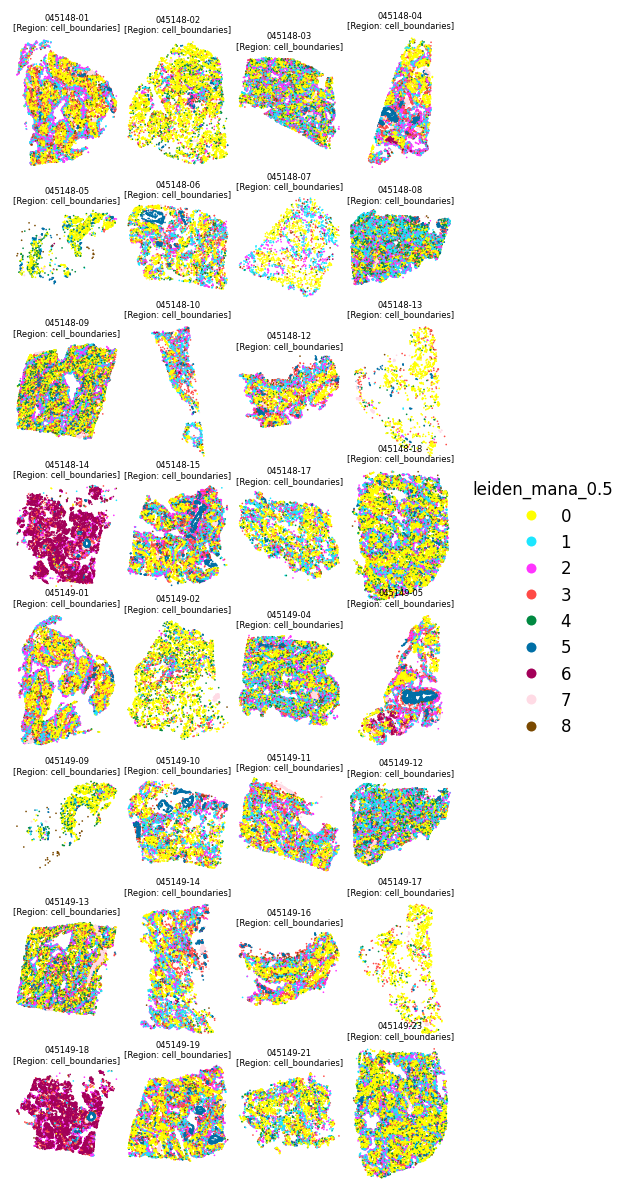

In [23]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    ad_sub, 
    color='leiden_mana_0.5',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 1,
    cols=4,
    height=10,
    background='white',
    dpi=120,
   
)

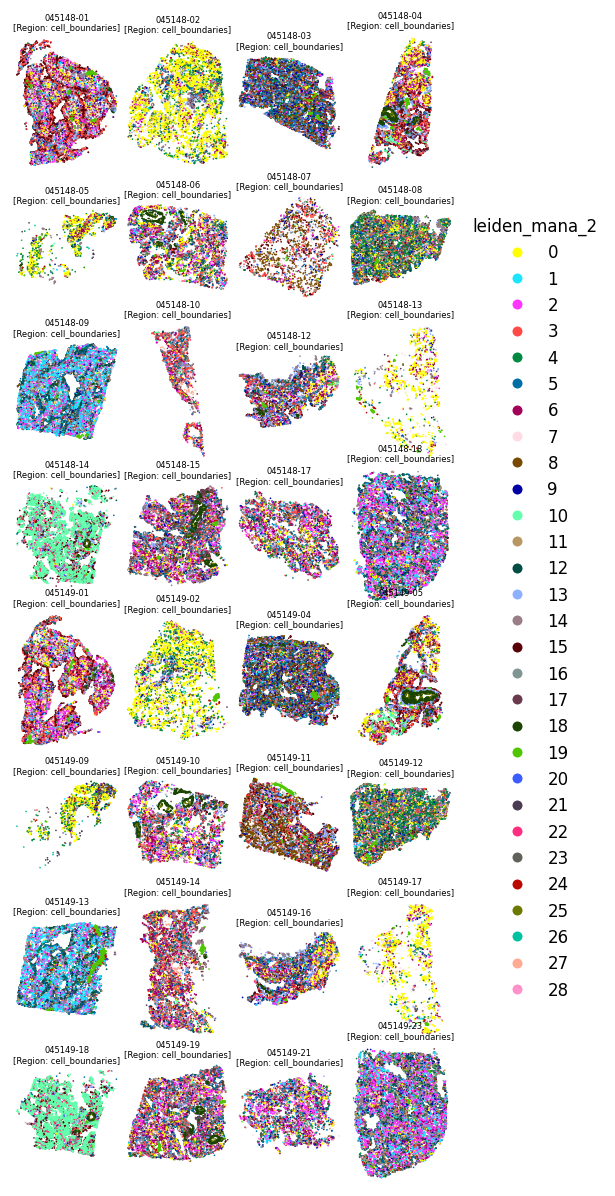

In [24]:
# Visualize MANA clustering (resolution 0.5 as starting point)
plot_spatial_compact_fast(
    ad_sub, 
    color='leiden_mana_2',
    groupby='sample_id',  # Adjust to your actual sample column
    spot_size = 1,
    cols=4,
    height=10,
    background='white',
    dpi=120,
   
)

In [25]:
ad_sub.write('/Volumes/processing2/erectile_dysfunction/data/adata/ED_5k_filtered_clustered_cytetype_cellcharter_metadata_subset_updated_mana.h5ad')

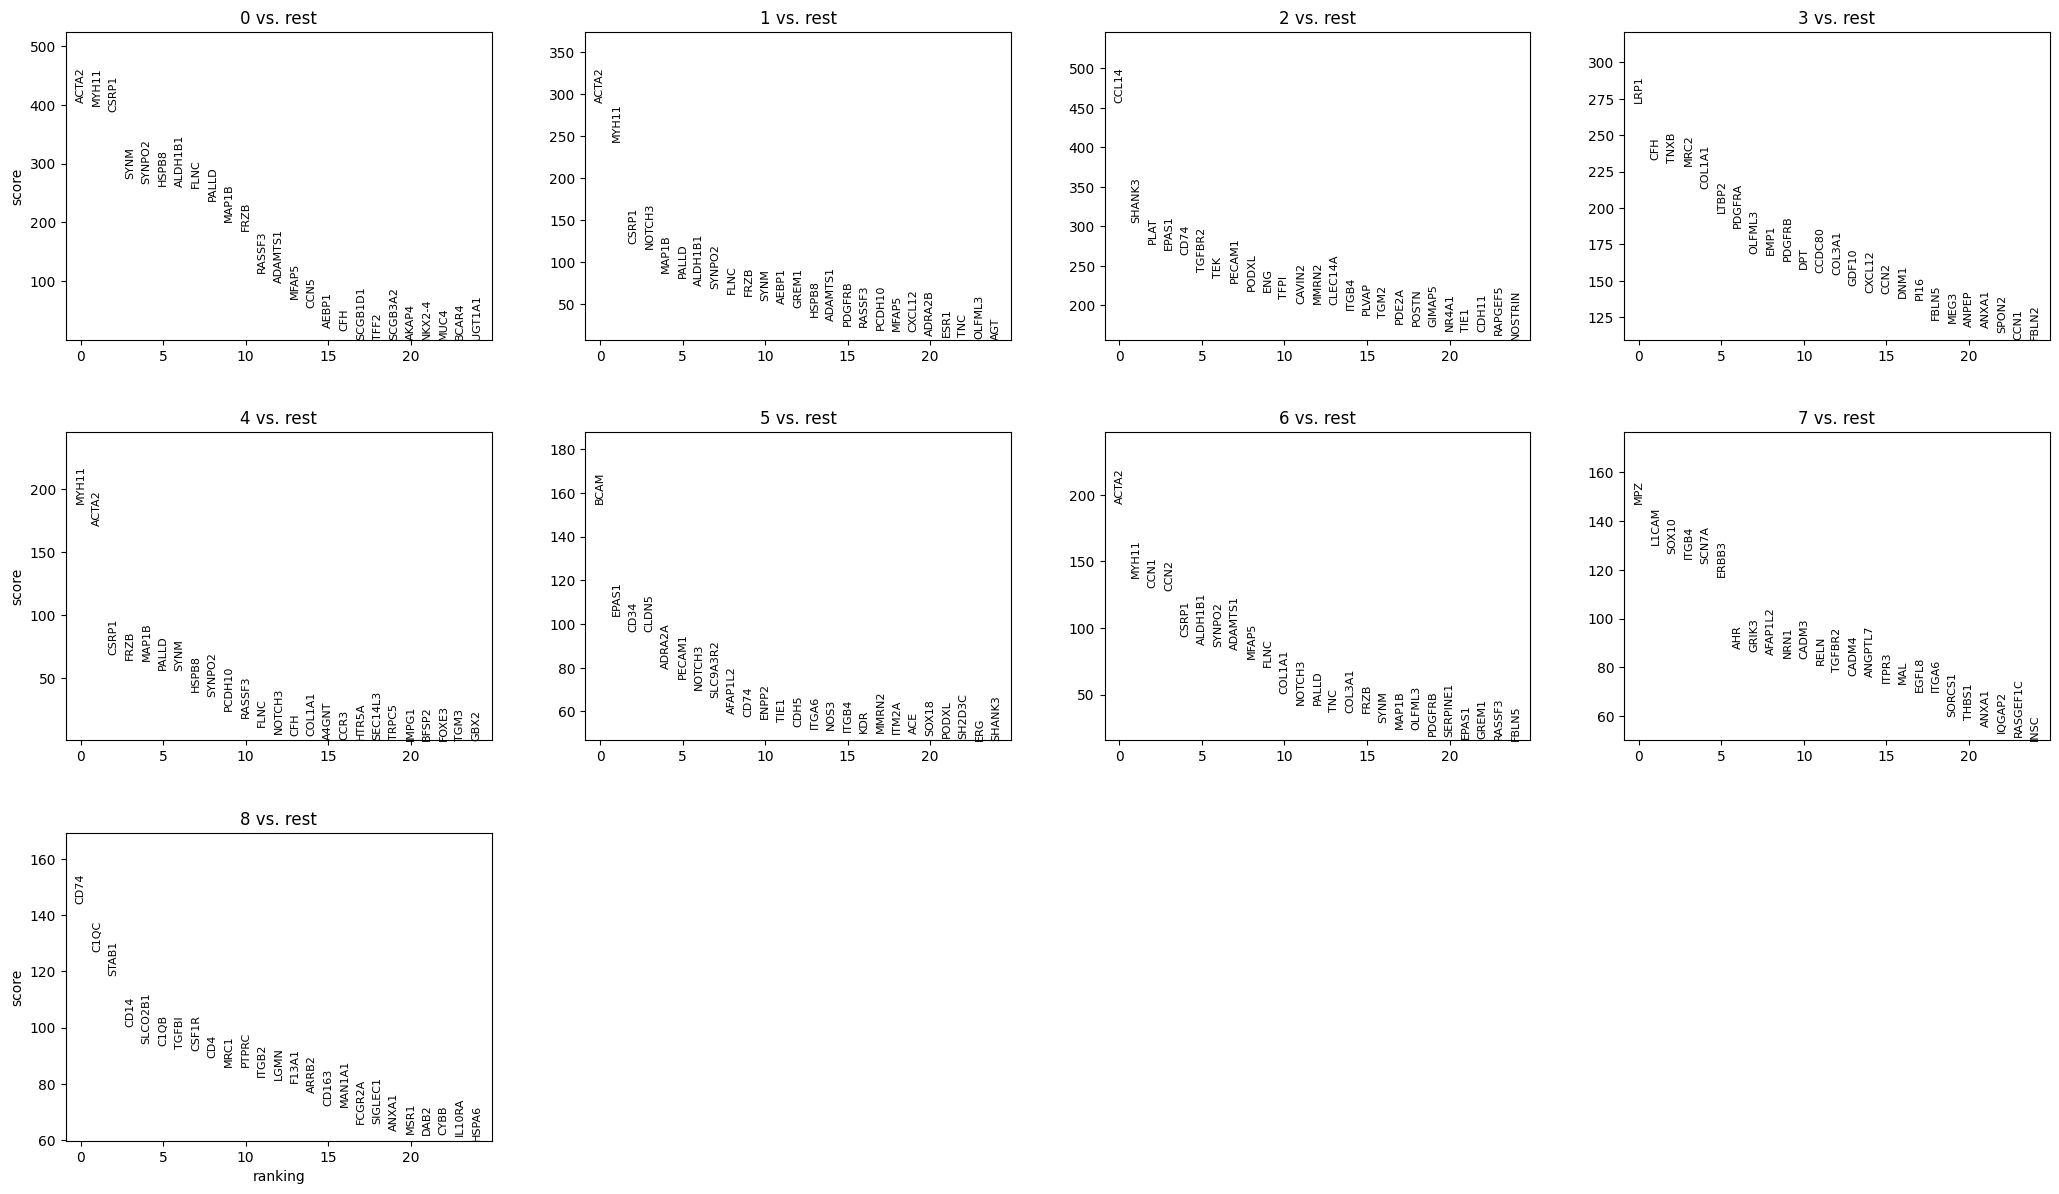

0
ACTA2 MYH11 CSRP1 SYNM SYNPO2 HSPB8 ALDH1B1 FLNC PALLD MAP1B FRZB RASSF3 ADAMTS1 MFAP5 CCN5 AEBP1 CFH SCGB1D1 TFF2 SCGB3A2 AKAP4 NKX2-4 MUC4 BCAR4 UGT1A1 IFNL2 IL5 APELA KCNK16 C8B
 
1
ACTA2 MYH11 CSRP1 NOTCH3 MAP1B PALLD ALDH1B1 SYNPO2 FLNC FRZB SYNM AEBP1 GREM1 HSPB8 ADAMTS1 PDGFRB RASSF3 PCDH10 MFAP5 CXCL12 ADRA2B ESR1 TNC OLFML3 AGT IGFN1 STC2 A4GNT CALR3 KCNJ6
 
2
CCL14 SHANK3 PLAT EPAS1 CD74 TGFBR2 TEK PECAM1 PODXL ENG TFPI CAVIN2 MMRN2 CLEC14A ITGB4 PLVAP TGM2 PDE2A POSTN GIMAP5 NR4A1 TIE1 CDH11 RAPGEF5 NOSTRIN EMP1 ERG GIMAP8 EGFL7 KLF4
 
3
LRP1 CFH TNXB MRC2 COL1A1 LTBP2 PDGFRA OLFML3 EMP1 PDGFRB DPT CCDC80 COL3A1 GDF10 CXCL12 CCN2 DNM1 PI16 FBLN5 MEG3 ANPEP ANXA1 SPON2 CCN1 FBLN2 IL16 MAN1A1 BMP5 IGF1 SFRP1
 
4
MYH11 ACTA2 CSRP1 FRZB MAP1B PALLD SYNM HSPB8 SYNPO2 PCDH10 RASSF3 FLNC NOTCH3 CFH COL1A1 A4GNT CCR3 HTR5A SEC14L3 TRPC5 IMPG1 BFSP2 FOXE3 TGM3 GBX2 UGT1A1 TGM6 SAA4 PAX6 FDCSP
 
5
BCAM EPAS1 CD34 CLDN5 ADRA2A PECAM1 NOTCH3 SLC9A3R2 AFAP1L2 CD74 ENPP2 TIE1 CDH5 ITGA6

In [26]:
import pandas as pd
key = "leiden_mana_0.5"              # <-- change to your cluster column

sc.tl.rank_genes_groups(
    ad_sub,
    groupby=key,
    reference="rest",             # each group vs all other cells
    method="t-test",
    pts=True,                     # add fraction expressing
)
sc.pl.rank_genes_groups(ad_sub, n_genes=25, sharey=False)

marker_genes = pd.DataFrame({
    group: ad_sub.uns['rank_genes_groups']['names'][group][:30]
    for group in ad_sub.uns['rank_genes_groups']['names'].dtype.names
})
for col in marker_genes.columns: 
    print(col)
    genes = marker_genes[col].tolist()

    print(" ".join(genes))
    print(' ')